# How well do different adaptive algorithms perform?
This script will see how the adaptive algorithm out-preforms the passive algorithm.

It does this by seeing how many rankings are considered the funniest ranking. For each caption we have a mean and a standard deviation. If the first rated caption has mean $\mu_1$ and std.dev. of $\sigma_1$, we want how many captions $i$ have $\mu_i + \sigma_i > \mu_1 - \sigma_1$.

### Metrics
* Number of "top captions"
* Prob. funniest caption in top 10

In [1]:
import numpy as np

In [2]:
import caption_contest_data as ccd

In [3]:
df1 = ccd.responses("559-active", path="../contests/responses/")
df2 = ccd.responses("559-passive", path="../contests/responses/")
df1.target_id.nunique(), df2.target_id.nunique()

(5012, 138)

In [39]:
import pandas as pd
df = df1
df.iloc[0]

alg_label                                                                KLUCB
network_delay                                                         0.268106
participant_uid              c84f9a4715e586b920096d5d1c0b38_Aqe3oWWqGrM6HYC...
response_time                                                            9.387
target                                                Enjoy your spring break!
target_id                                                                  478
target_reward                                                                2
timestamp_query_generated                           2017-03-06 15:01:46.733847
label                                                           somewhat_funny
contest                                                                    559
filename                                              559-active-responses.csv
Name: 297107, dtype: object

In [40]:
df.dtypes

alg_label                            object
network_delay                       float64
participant_uid                      object
response_time                       float64
target                               object
target_id                             int64
target_reward                         int64
timestamp_query_generated    datetime64[ns]
label                                object
contest                              object
filename                             object
dtype: object

In [23]:
df.memory_usage().sum() / 1024**2, "MB"

(45.763916015625, 'MB')

In [82]:
df1.timestamp_query_generated.min(), df2.timestamp_query_generated.min()

(Timestamp('2017-03-06 15:01:46.733847'),
 Timestamp('2017-03-07 20:07:07.962230'))

In [104]:
start = pd.Timestamp('2017-03-06 15:01:46.733847')
time_diff1 = df1.timestamp_query_generated - start
time_diff2 = df2.timestamp_query_generated - start

time_d1 = time_diff1.apply(lambda x: x.total_seconds() / (60 * 60 * 24))
time_d2 = time_diff2.apply(lambda x: x.total_seconds() / (60 * 60 * 24))

Text(0, 0.5, 'Number of responses')

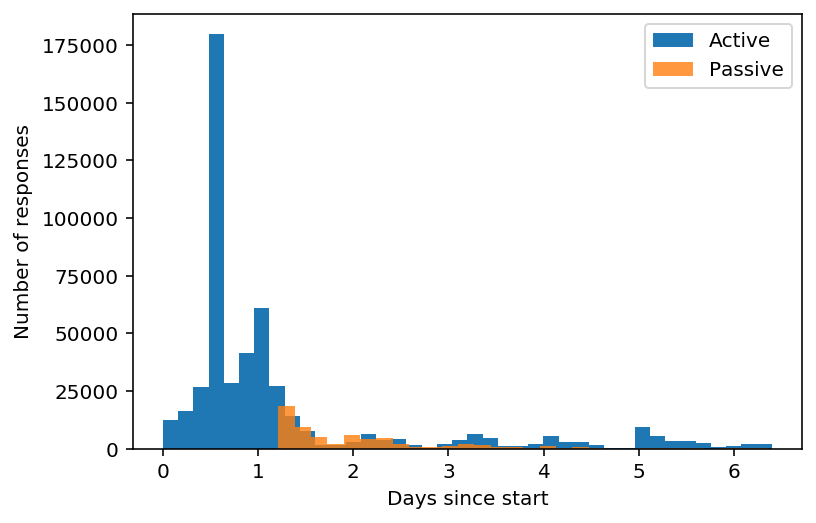

In [110]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
time_d1.plot.hist(ax=ax, bins=40, label="Active")
time_d2.plot.hist(ax=ax, bins=30, alpha=0.8, label="Passive")
ax.legend(loc="best")
ax.set_xlabel("Days since start")
ax.set_ylabel("Number of responses")

In [24]:
df.sort_values(by="timestamp_query_generated", inplace=True)

In [8]:
import caption_contest_data._raw as raw

In [51]:
scores = df.pivot_table(
    index="target_id",
    values="target_reward",
    columns="alg_label",
    aggfunc=np.mean,
)
top_scores = {alg: (scores[alg].idxmax(), scores[alg].max()) for alg in ["KLUCB", "LilUCB"]}
top_scores

{'KLUCB': (1559, 1.7674418604651163), 'LilUCB': (387, 1.8341463414634147)}

In [54]:
num_responses = df.pivot_table(
    index="alg_label",
    values="target_reward",
    aggfunc=len,
)
num_responses

,target_reward
alg_label,
KLUCB,250564
LilUCB,249300


In [68]:
def get_stats(df, alg_label, num_responses, top_id, top=10):
    idx = (df.alg_label == alg_label)
    s = df[idx]
    idx = np.arange(len(s)) <= num_responses
    show = s.iloc[idx]
    counts = show.pivot_table(
        columns="label",
        index="target_id",
        values="response_time",
        aggfunc=len,
    )
    count = counts.sum(axis=1)
    counts.fillna(0, inplace=True)
    score, prec = raw.score_and_prec(counts["unfunny"], counts["somewhat_funny"], counts["funny"], count)

    stats = pd.DataFrame({"score": score, "prec": prec})
    stats.sort_values(by="score", ascending=False, inplace=True)
    top_rank = np.argwhere(stats.index == top_id).item() + 1

    top_cap = stats.loc[stats.score.idxmax()]
    num_top_captions = (top_cap["score"] - top_cap["prec"] < score).sum()
    return {
        "num_top": num_top_captions,
        "top_in_top": top_id in stats.index[:10],
        "top": top,
        "num_responses": num_responses,
        "alg_label": alg_label,
        "top_rank": top_rank,
    }

In [69]:
data = []
for k, num_responses in enumerate(np.linspace(10e3, 250e3, num=200).astype(int)):
    for alg_label in ["KLUCB", "LilUCB"]:
        if k % 20 == 0:
            print(k, num_responses)
        datum = get_stats(df, alg_label, num_responses, top_ids[alg_label][0])
        data.append(datum)

0 10000
0 10000
20 34120
20 34120
40 58241
40 58241
60 82361
60 82361
80 106482
80 106482
100 130603
100 130603
120 154723
120 154723
140 178844
140 178844
160 202964
160 202964
180 227085
180 227085


In [70]:
show = pd.DataFrame(data)

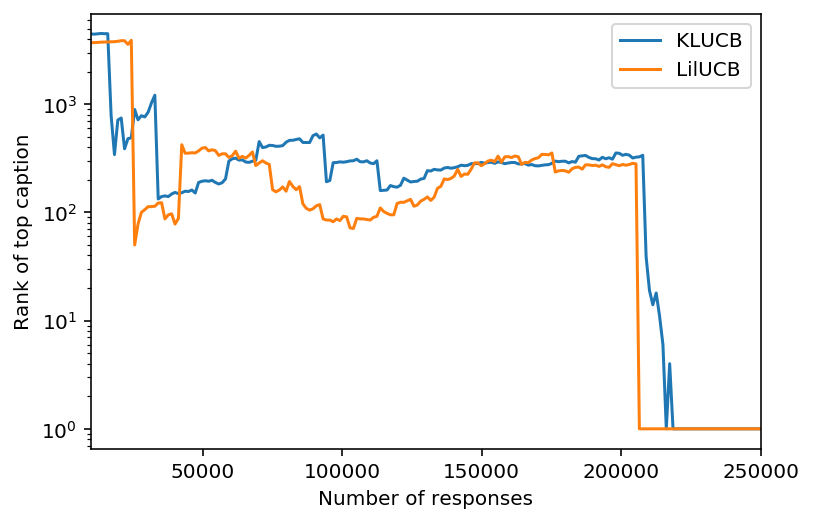

In [71]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for alg in show.alg_label.unique():
    show[show.alg_label == alg].plot(x="num_responses", y="top_rank", ax=ax, label=alg)
ax.set_ylabel("Rank of top caption")
ax.set_xlabel("Number of responses")
ax.set_yscale("log")

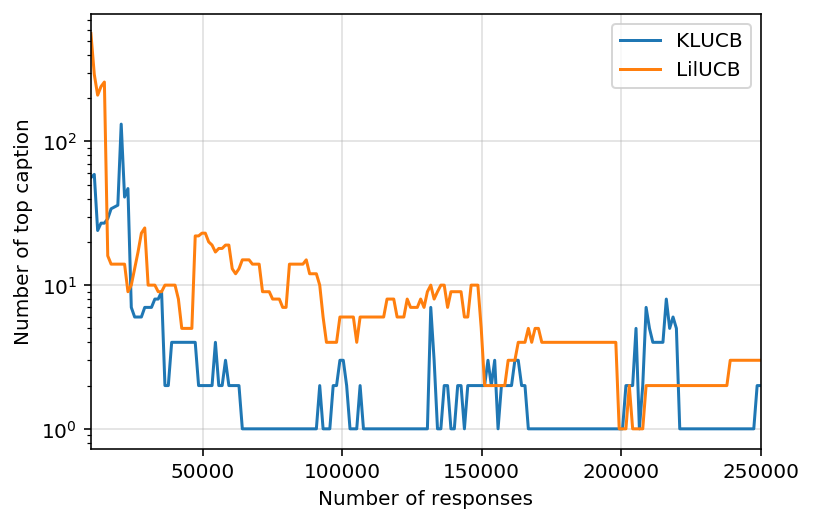

In [72]:
fig, ax = plt.subplots()
for alg in show.alg_label.unique():
    show[show.alg_label == alg].plot(x="num_responses", y="num_top", ax=ax, label=alg)
ax.set_ylabel("Number of top caption")
ax.set_xlabel("Number of responses")
# ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(alpha=0.4)